In [2]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
from scipy.interpolate import interp1d
import pickle

import importlib.util
import sys

In [4]:
# This messiness is necessary to import scripts which are not installed and
# which are not located in the cwd.

spec = importlib.util.spec_from_file_location(
    "camb_interface", "../../../cassL/camb_interface.py")
ci = importlib.util.module_from_spec(spec)
sys.modules["camb_interface"] = ci
spec.loader.exec_module(ci)

spec = importlib.util.spec_from_file_location(
    "generate_emu_data", "../../../cassL/generate_emu_data.py")
ged = importlib.util.module_from_spec(spec)
sys.modules["generate_emu_data"] = ged
spec.loader.exec_module(ged)

spec = importlib.util.spec_from_file_location(
    "andreap", "../andreap.py")
andreap = importlib.util.module_from_spec(spec)
sys.modules["andreap"] = andreap
spec.loader.exec_module(andreap)

In [6]:
# Get the latin hypercubes so that we know which values to use for our test
# cosmological configurations.

hc = np.load("../G_versions/hc_G6.npy",
    allow_pickle=True)
samples = np.load("../G_versions/samples_G6.npy",
    allow_pickle=True)
    
standard_k = np.load("../standard_k.npy", allow_pickle=True)

In [7]:
# Load the emulator so that we can compare our results with, say, Andrea's

m = pickle.load(open("../analyses/massive_emulator_G3_full.nucomet", "rb"))

def inverse_transform(raw_prediction):
    return np.exp(raw_prediction * m.stdev + m.mu)

def nest(array):
    return np.array([np.array(array)])

In [8]:
# Select an individual cosmology to interrogate
test_index = 400
test_cosmology = hc[test_index]
test_pspec = samples[test_index]

In [9]:
# Break the configuration into explicit labels
ombh2 = test_cosmology[0]
omch2 = test_cosmology[1]
ns = test_cosmology[2]
sigma12 = test_cosmology[3]
As = test_cosmology[4]
omnuh2 = test_cosmology[5]

In [10]:
# Get an emulator-readable cosmology object based off of these parameters
full_cosm = ged.build_cosmology(ombh2, omch2, ns, sigma12, As, omnuh2)

In [11]:
# What is the value of mnu automatically calculated based off of the input
# omega_nuh2 value?
mnu = full_cosm['mnu']

In [12]:
# What would we get if we called CAMB again on this configuration?
g_pspec, g_sigma12, g_rescale = ged.evaluate_cell(full_cosm, standard_k)
g_z = g_rescale[1]
print("This is our approximation", g_sigma12)

This is our approximation 0.6828000376065132


In [13]:
# Get power spectrum interpolator objects representing Andrea's values for the
# power spectra.
if not fast:
    Pk_lo_h = andreap.get_PK(ombh2, omch2, ns, omnuh2, 10, As)
    Pk_hi_h = andreap.get_PK(ombh2, omch2, ns, mnu, 67, As)
    Pk_target_h = andreap.get_PK(ombh2, omch2, ns, mnu, 57, As)

In [14]:
# FOR THIS PARTICULAR TEST CASE (index 400, training set), h was not moved, and
# the following line is accurate
andrea_spectrum = Pk_hi_h['mnu'].P(g_z, standard_k)

Text(0.5, 1.0, "Andrea's power spectrum")

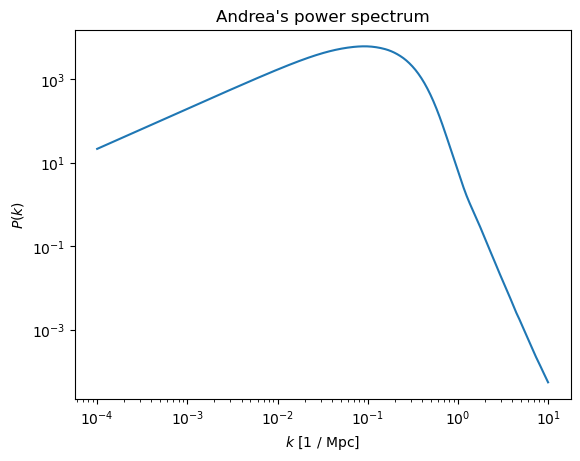

In [15]:
# What does Andrea's power spectrum look like here?
andrea_spectrum.shape
plt.loglog(standard_k, andrea_spectrum)
plt.xlabel('$k$ [1 / Mpc]')
plt.ylabel('$P(k)$')
plt.title('Andrea\'s power spectrum')

Text(0.5, 1.0, "Andrea's power spectrum vs. Lukas' emu training spectrum")

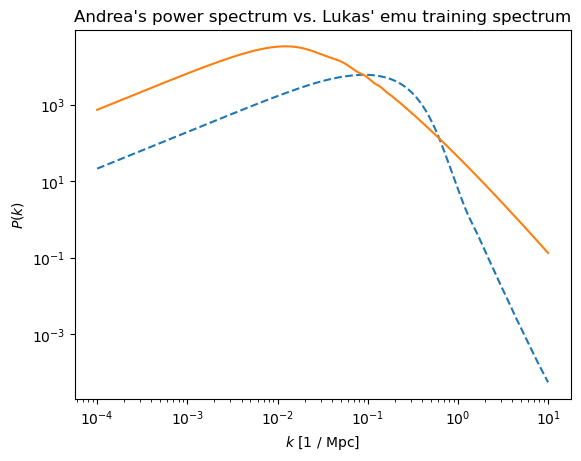

In [16]:
# Overplot comparison: Andrea's spectrum vs mine
plt.loglog(standard_k, andrea_spectrum, linestyle='dashed')
plt.loglog(standard_k, g_pspec)
plt.xlabel('$k$ [1 / Mpc]')
plt.ylabel('$P(k)$')
plt.title('Andrea\'s power spectrum vs. Lukas\' emu training spectrum')

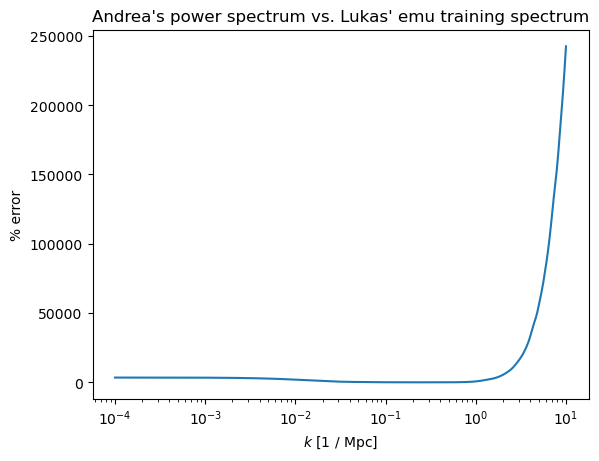

In [17]:
# Percent error comparison
plt.plot(standard_k,
         (g_pspec - andrea_spectrum) / andrea_spectrum * 100)
plt.xscale('log')
plt.xlabel('$k$ [1 / Mpc]')
plt.ylabel('% error')
plt.title('Andrea\'s power spectrum vs. Lukas\' emu training spectrum')
plt.savefig("../../plots/emulator/debugging/Andrea_old_discrepancy.png")

In [18]:
# What happens if we, too, grab an interpolator object?
my_PI = ci.cosmology_to_PK_interpolator(
    full_cosm, redshifts=[g_z], kmax=10)
PI_result = my_PI.P(g_z, standard_k)

Text(0.5, 1.0, "Andrea's power spectrum vs. Lukas' interpolator")

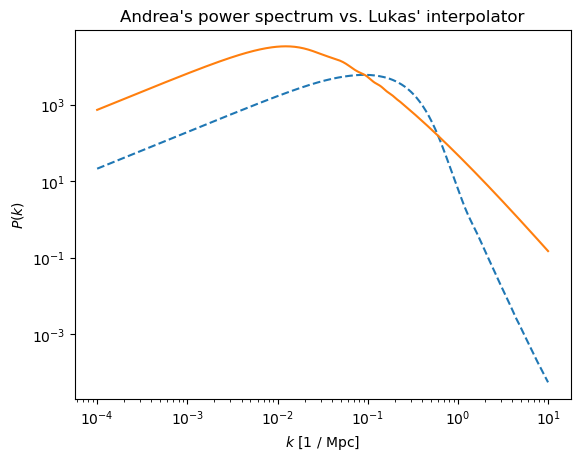

In [19]:
# Overplot comparison: Andrea's spectrum vs mine
plt.loglog(standard_k, andrea_spectrum, linestyle='dashed')
plt.loglog(standard_k, PI_result)
plt.xlabel('$k$ [1 / Mpc]')
plt.ylabel('$P(k)$')
plt.title('Andrea\'s power spectrum vs. Lukas\' interpolator')

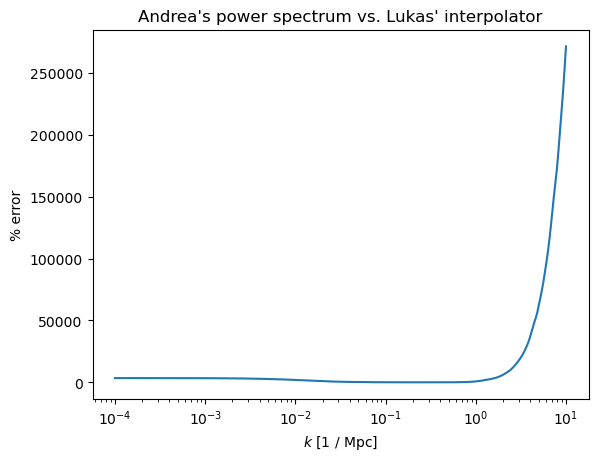

In [20]:
# Percent error comparison
plt.plot(standard_k,
         (PI_result - andrea_spectrum) / andrea_spectrum * 100)
plt.xscale('log')
plt.xlabel('$k$ [1 / Mpc]')
plt.ylabel('% error')
plt.title('Andrea\'s power spectrum vs. Lukas\' interpolator')
plt.savefig("../../plots/emulator/debugging/Andrea_new_discrepancy.png")

In [21]:
if not fast:
    z = np.linspace(0., 5., 500)
    sig12 = np.zeros(500)
    for i in range(500):
        sig12[i] = andreap.get_s12(Pk_hi_h['mzero'], z[i])

    sig12[0]
    
    sig12_interpolator = interp1d(sig12, z, kind='cubic')

In [22]:
sigma12

0.6828000175643023

In [23]:
import copy as cp
tilde_cosm = cp.deepcopy(full_cosm)
tilde_cosm['omch2'] += tilde_cosm['omnuh2']
tilde_cosm = ci.specify_neutrino_mass(tilde_cosm, 0, 0)
ged.print_cosmology(tilde_cosm)
print()
ged.print_cosmology(full_cosm)

ombh2 0.020643445
omch2 0.157262
n_s 0.9599150000000001
A_s 3.8168072145531776e-09
OmK 0.0
OmL 0.681415906
h 0.67
w0 -1.0
wa 0.00
sigma12 0.6828000175643023
omnuh2 0
mnu 0.0

ombh2 0.020643445
omch2 0.147433
n_s 0.9599150000000001
A_s 3.8168072145531776e-09
OmK 0.0
OmL 0.681415906
h 0.67
w0 -1.0
wa 0.00
sigma12 0.6828000175643023
omnuh2 0.009829000000000001
mnu 0.9141294348168427


In [24]:
kci_t, zci_t, pci_t, sci_t = ci.evaluate_cosmology(tilde_cosm, redshifts=[g_rescale[1]], k_points=300)
kci, zci, pci, sci = ci.evaluate_cosmology(full_cosm, redshifts=[g_rescale[1]], k_points=300)

In [25]:
sci

array([0.56179428])

In [26]:
g_pspec_t, g_sigma12_t, g_z_t = ged.evaluate_cell(tilde_cosm, standard_k)
print("This is our approximation", g_sigma12_t)

This is our approximation 0.6828000376065132


In [27]:
if not fast:
    andreap.get_s12(Pk_hi_h['mzero'], 0)

In [28]:
# I cannot figure out how to get AndreaP's function to work
#andreap.get_s12_fixedz(Pk_hi_h['mzero'])

In [29]:
raw_pred_emulator, _ = m.predict(nest(test_cosmology))
pred_emulator = inverse_transform(raw_pred_emulator)[0]

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

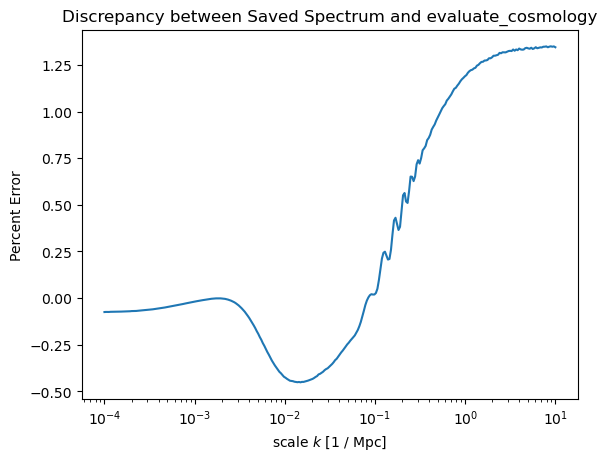

In [30]:
plt.plot(standard_k, (pci - pred_emulator) / pred_emulator * 100)
plt.xscale('log')
plt.title("Discrepancy between Saved Spectrum and evaluate_cosmology")
plt.ylabel('Percent Error')
plt.xlabel('scale $k$ [1 / Mpc]')

In [31]:
test_cosmology

array([2.06434450e-02, 1.47433000e-01, 9.59915000e-01, 6.82800018e-01,
       3.81680721e-09, 9.82900000e-03])

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

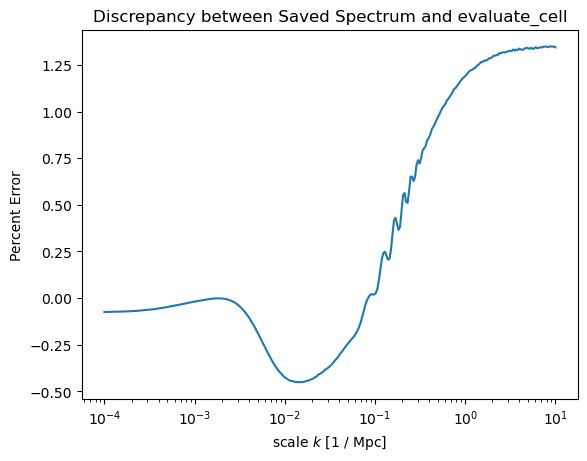

In [32]:
plt.plot(standard_k, (g_pspec - pred_emulator) / pred_emulator * 100)
plt.xscale('log')
plt.title("Discrepancy between Saved Spectrum and evaluate_cell")
plt.ylabel('Percent Error')
plt.xlabel('scale $k$ [1 / Mpc]')

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

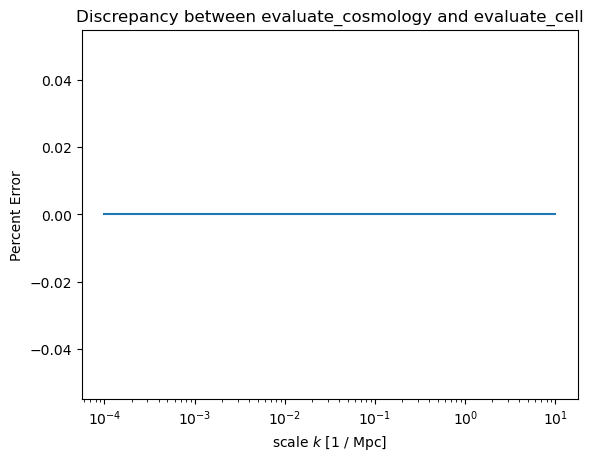

In [33]:
plt.plot(standard_k, (pci - g_pspec) / pci * 100)
plt.xscale('log')
plt.title("Discrepancy between evaluate_cosmology and evaluate_cell")
plt.ylabel('Percent Error')
plt.xlabel('scale $k$ [1 / Mpc]')

This most recent plot is weak enough that we're happy. But why do we see differences in the previous plots? Is this a reproduceable discrepancy?

In [34]:
resample, bestz = ged.fill_hypercube(hc, standard_k, massive_neutrinos=True,
    cell_range=range(1))
resample = resample[0]

nnu_massive: 0
nnu_massive: 0
nnu_massive: 1
0 complete


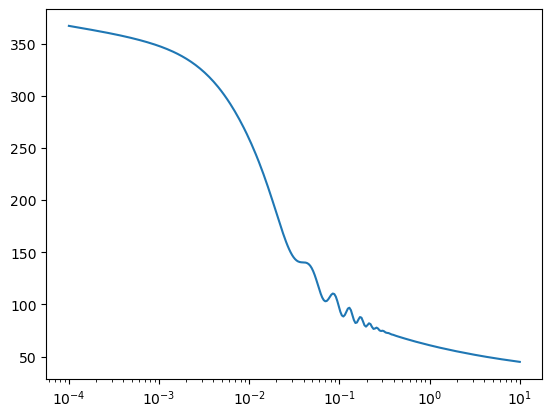

In [35]:
plt.plot(standard_k,
    (resample - pred_emulator) / pred_emulator * 100)
plt.xscale('log')